## Loading Libraries

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow import keras

from dataset_loader.data_loader import load_mnist_dataset
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, MaxPooling2D, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import os
import matplotlib.pyplot as plt
from utils.CustomLayers.binary_layers import BinaryConv2D, BinaryDense
from utils.CustomLayers.ternary_layers import TernaryConv2D, TernaryDense
from utils.CustomOperations.binary_ops import binarize,binary_tanh
from utils.CustomOperations.ternary_ops import ternarize
from utils.CustomActivations.activations import ternary_tanh
from utils.CustomCallbacks.callbacks import CustomLearningRateScheduler
import tensorflow.keras.utils as np_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading MNIST Dataset

In [3]:
X_train, Y_train, X_test, Y_test = load_mnist_dataset()

In [4]:
X_train.shape,Y_train.shape,X_test.shape,Y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

In [5]:
H = 1.
kernel_lr_multiplier = 'Glorot'
batch_size = 50
epochs = 20 
channels = 1
img_rows = 28 
img_cols = 28 
filters = 32 
kernel_size = (3, 3)
pool_size = (2, 2)
hidden_units = 128
classes = 10
use_bias = False
epsilon = 1e-6
momentum = 0.9
p1 = 0.25
p2 = 0.5

## Alexnet Binarised

In [75]:
AlexnetBinary = Sequential()
AlexnetBinary.add(BinaryConv2D(96, kernel_size=(11,11), input_shape=(channels,img_rows, img_cols),
                       data_format='channels_first', strides = 4,
                       H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                       padding='same', use_bias=use_bias, name='conv1'))
AlexnetBinary.add(MaxPooling2D(pool_size=(3,3), name='pool1',strides = 2, data_format='channels_first', padding='same'))
AlexnetBinary.add(BinaryConv2D(256, kernel_size=(5,5),
                               H=H,
                               kernel_lr_multiplier=kernel_lr_multiplier,
                               data_format='channels_first',
                               padding='same',
                               use_bias=use_bias,
                               name='conv2'))
AlexnetBinary.add(MaxPooling2D(pool_size=(3,3),
                               name='pool2',
                               strides = 2,
                               data_format='channels_first',
                               padding='same'))
AlexnetBinary.add(BinaryConv2D(384, kernel_size=(3,3),
                               H=H,
                               kernel_lr_multiplier=kernel_lr_multiplier,
                               data_format='channels_first',
                               padding='same', use_bias=use_bias, name='conv3'))
AlexnetBinary.add(BinaryConv2D(384, kernel_size=(3,3),
                               H=H,
                               kernel_lr_multiplier=kernel_lr_multiplier,
                               data_format='channels_first',
                               padding='same', use_bias=use_bias, name='conv4'))
AlexnetBinary.add(BinaryConv2D(256, kernel_size=(3,3),
                               H=H,
                               kernel_lr_multiplier=kernel_lr_multiplier,
                               data_format='channels_first',
                               padding='same', use_bias=use_bias, name='conv5'))
AlexnetBinary.add(MaxPooling2D(pool_size=pool_size, strides = 2, name='pool4', data_format='channels_first'))
AlexnetBinary.add(Dropout(0.5))
AlexnetBinary.add(Flatten())
AlexnetBinary.add(BinaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense1'))
AlexnetBinary.add(Dropout(0.5))
AlexnetBinary.add(BinaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense2'))
AlexnetBinary.add(Dense(10, name='dense3', activation="softmax"))


AlexnetBinary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)
lr_scheduler = LearningRateScheduler(CustomLearningRateScheduler)
AlexnetBinary.summary()
AlexnetBinaryHistory = AlexnetBinary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (BinaryConv2D)         (None, 96, 7, 7)          11616     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 96, 4, 4)          0         
_________________________________________________________________
conv2 (BinaryConv2D)         (None, 256, 4, 4)         614400    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 256, 2, 2)         0         
_________________________________________________________________
conv3 (BinaryConv2D)         (None, 384, 2, 2)         884736    
_________________________________________________________________
conv4 (BinaryConv2D)         (None, 384, 2, 2)         1327104   
_________________________________________________________________
conv5 (BinaryConv2D)         (None, 256, 2, 2)       

## Alexnet Ternarised

In [74]:
from tensorflow.keras import backend as K
AlexnetTernary = Sequential()
AlexnetTernary.add(TernaryConv2D(96, kernel_size=(11,11),
                                 input_shape=(channels,img_rows, img_cols),
                                 strides = 4,
                                 H=H,
                                 kernel_lr_multiplier=kernel_lr_multiplier, 
                                 padding='same',
                                 use_bias=use_bias,
                                 name='conv1'))
AlexnetTernary.add(MaxPooling2D(pool_size=(3,3),
                                name='pool1',strides = 2, data_format='channels_first', padding="same"))
AlexnetTernary.add(TernaryConv2D(256, kernel_size=(5,5),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv2'))
AlexnetTernary.add(MaxPooling2D(pool_size=(3,3), name='pool2', strides = 2, data_format='channels_first', padding="same"))
AlexnetTernary.add(TernaryConv2D(384, kernel_size=(3,3),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv3'))
AlexnetTernary.add(TernaryConv2D(384, kernel_size=(3,3),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv4'))
AlexnetTernary.add(TernaryConv2D(256, kernel_size=(3,3),
                        H=H, kernel_lr_multiplier=kernel_lr_multiplier, 
                        padding='same', use_bias=use_bias, name='conv5'))
AlexnetTernary.add(MaxPooling2D(pool_size=pool_size, strides = 2, name='pool3', data_format='channels_first', padding="same"))
AlexnetTernary.add(Dropout(0.5))
AlexnetTernary.add(Flatten())
AlexnetTernary.add(TernaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense1'))
AlexnetTernary.add(Dropout(0.5))
AlexnetTernary.add(TernaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense2'))
AlexnetTernary.add(Dense(10, name='dense3', activation="softmax"))
AlexnetTernary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)
lr_scheduler = LearningRateScheduler(CustomLearningRateScheduler)
AlexnetTernary.summary()
AlexnetTernaryHistory = AlexnetTernary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (TernaryConv2D)        (None, 1, 7, 96)          325248    
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1, 4, 48)          0         
_________________________________________________________________
conv2 (TernaryConv2D)        (None, 1, 4, 256)         307200    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 1, 2, 128)         0         
_________________________________________________________________
conv3 (TernaryConv2D)        (None, 1, 2, 384)         442368    
_________________________________________________________________
conv4 (TernaryConv2D)        (None, 1, 2, 384)         1327104   
_________________________________________________________________
conv5 (TernaryConv2D)        (None, 1, 2, 256)       

## Alexnet Full Precision

In [39]:
AlexnetFP = Sequential()
AlexnetFP.add(Conv2D(96, kernel_size=(11,11), input_shape=(channels,img_rows, img_cols),strides = 4, 
                     padding='same', use_bias=use_bias, name='conv1',activation="relu"))
AlexnetFP.add(MaxPooling2D(pool_size=(3,3), name='pool1',strides = 2, data_format='channels_first', padding="same"))
AlexnetFP.add(Conv2D(256, kernel_size=(5,5),padding='same', use_bias=use_bias, name='conv2', activation="relu"))
AlexnetFP.add(MaxPooling2D(pool_size=(3,3), name='pool2', strides = 2, data_format='channels_first', padding="same"))
AlexnetFP.add(Conv2D(384, kernel_size=(3,3),
                        padding='same', use_bias=use_bias, name='conv3', activation="relu"))
AlexnetFP.add(Conv2D(384, kernel_size=(3,3),
                        padding='same', use_bias=use_bias, name='conv4', activation="relu"))
AlexnetFP.add(Conv2D(256, kernel_size=(3,3),
                      padding='same',
                      use_bias=use_bias,
                      name='conv5',
                      activation="relu"))
AlexnetFP.add(MaxPooling2D(pool_size=pool_size, strides = 2, name='pool3', data_format='channels_first', padding="same"))
AlexnetFP.add(Dropout(0.5))
AlexnetFP.add(Flatten())
AlexnetFP.add(Dense(4096,  use_bias=use_bias, name='dense1', activation="relu"))
AlexnetFP.add(Dropout(0.5))
AlexnetFP.add(Dense(4096,  use_bias=use_bias, name='dense2', activation="relu"))
AlexnetFP.add(Dense(10,  name='dense3', activation="softmax"))


lr_scheduler = LearningRateScheduler(CustomLearningRateScheduler)


AlexnetFP.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

AlexnetFP.summary()

AlexnetFPhistory = AlexnetFP.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 1, 7, 96)          325248    
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 1, 4, 48)          0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 4, 256)         307200    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 1, 2, 128)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 1, 2, 384)         442368    
_________________________________________________________________
conv4 (Conv2D)               (None, 1, 2, 384)         1327104   
_________________________________________________________________
conv5 (Conv2D)               (None, 1, 2, 256)       

## VGG16 Binarised

In [66]:
VGG16Binary = Sequential()
VGG16Binary.add(BinaryConv2D(input_shape=(channels,img_rows, img_cols),
                             filters=64,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=64,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                             use_bias=use_bias))
VGG16Binary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                             data_format='channels_first'))
VGG16Binary.add(BinaryConv2D(filters=128, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=128, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                             data_format='channels_first'))
VGG16Binary.add(BinaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                            data_format='channels_first'))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                            data_format='channels_first'))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(BinaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                             data_format='channels_first'))
VGG16Binary.add(Flatten())
VGG16Binary.add(BinaryDense(units=4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Binary.add(Activation('relu', name='act1'))
VGG16Binary.add(Dense(units=4096,activation="relu"))
VGG16Binary.add(Dense(10, name='dense3', activation="softmax"))
VGG16Binary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

VGG16Binary.summary()

VGG16Binaryhistory = VGG16Binary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
binary_conv2d_39 (BinaryConv (None, 1, 28, 64)         16128     
_________________________________________________________________
binary_conv2d_40 (BinaryConv (None, 1, 28, 64)         36864     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 1, 14, 32)         0         
_________________________________________________________________
binary_conv2d_41 (BinaryConv (None, 1, 14, 128)        36864     
_________________________________________________________________
binary_conv2d_42 (BinaryConv (None, 1, 14, 128)        147456    
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 1, 7, 64)          0         
_________________________________________________________________
binary_conv2d_43 (BinaryConv (None, 1, 7, 256)       

## VGG16 Ternarised

In [67]:
VGG16Ternary = Sequential()
VGG16Ternary.add(TernaryConv2D(input_shape=(channels,img_rows, img_cols),filters=64,kernel_size=(3,3),padding="same", H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=64,kernel_size=(3,3),padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))
VGG16Ternary.add(TernaryConv2D(filters=128, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=128, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))
VGG16Ternary.add(TernaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=256, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(TernaryConv2D(filters=512, kernel_size=(3,3), padding="same",
                               H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
VGG16Ternary.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same"))
VGG16Ternary.add(Flatten())
VGG16Ternary.add(TernaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense1'))
VGG16Ternary.add(TernaryDense(4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name='dense2'))
VGG16Ternary.add(Dense(10, name='dense3', activation="softmax"))
VGG16Ternary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

VGG16Ternary.summary()

VGG16Ternaryhistory = VGG16Ternary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])



Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ternary_conv2d_71 (TernaryCo (None, 1, 28, 64)         16128     
_________________________________________________________________
ternary_conv2d_72 (TernaryCo (None, 1, 28, 64)         36864     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 1, 14, 64)         0         
_________________________________________________________________
ternary_conv2d_73 (TernaryCo (None, 1, 14, 128)        73728     
_________________________________________________________________
ternary_conv2d_74 (TernaryCo (None, 1, 14, 128)        147456    
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 1, 7, 128)         0         
_________________________________________________________________
ternary_conv2d_75 (TernaryCo (None, 1, 7, 256)       

## VGG16 Full Precision

In [68]:
VGG16FP = Sequential()
VGG16FP.add(Conv2D(input_shape=(channels,img_rows, img_cols),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG16FP.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
VGG16FP.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
VGG16FP.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG16FP.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
VGG16FP.add(Flatten())
VGG16FP.add(Dense(units=4096,activation="relu"))
VGG16FP.add(Dense(units=4096,activation="relu"))
VGG16FP.add(Dense(units=10, activation="softmax"))

VGG16FP.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

VGG16FP.summary()

VGG16FPhistory = VGG16FP.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 1, 28, 64)         16192     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 1, 28, 64)         36928     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 1, 14, 64)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 14, 128)        73856     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 1, 14, 128)        147584    
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 1, 7, 128)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 1, 7, 256)       

## LeNet 5 Binarised

In [48]:
LeNet5Binary = Sequential()
LeNet5Binary.add(BinaryConv2D(input_shape=(channels,img_rows, img_cols),
                             filters=6,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
LeNet5Binary.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5Binary.add(BinaryConv2D(filters=16,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                             use_bias=use_bias))
LeNet5Binary.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5Binary.add(Flatten())
LeNet5Binary.add(BinaryDense(units=120, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
LeNet5Binary.add(Activation("relu", name='act1'))
LeNet5Binary.add(BinaryDense(units=84, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
LeNet5Binary.add(Activation("relu", name='act2'))
LeNet5Binary.add(Dense(10, name='dense3', activation="softmax"))


LeNet5Binary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

LeNet5Binary.summary()

LeNet5Binaryhistory = LeNet5Binary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
binary_conv2d_20 (BinaryConv (None, 1, 28, 6)          1512      
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 14, 6)          0         
_________________________________________________________________
binary_conv2d_21 (BinaryConv (None, 1, 14, 16)         864       
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 7, 16)          0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 112)               0         
_________________________________________________________________
binary_dense_17 (BinaryDense (None, 120)               13440     
_________________________________________________________________
act1 (Activation)            (None, 120)             

## LeNet 5  Ternarised

In [7]:
LeNet5Ternary = Sequential()
LeNet5Ternary.add(TernaryConv2D(input_shape=(channels,img_rows, img_cols),
                             filters=6,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
LeNet5Ternary.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5Ternary.add(TernaryConv2D(filters=16,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                             use_bias=use_bias))
LeNet5Ternary.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5Ternary.add(Flatten())
LeNet5Ternary.add(TernaryDense(units=120, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name="dense1"))
LeNet5Ternary.add(Activation("relu", name='act1'))
LeNet5Ternary.add(TernaryDense(units=84, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias, name="dense2"))
LeNet5Ternary.add(Activation("relu", name='act2'))
LeNet5Ternary.add(Dense(10, name='dense3', activation="softmax"))


LeNet5Ternary.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

LeNet5Ternary.summary()
lr_scheduler = LearningRateScheduler(CustomLearningRateScheduler)
LeNet5Ternaryhistory = LeNet5Ternary.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ternary_conv2d_2 (TernaryCon (None, 1, 28, 6)          1512      
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 14, 6)          0         
_________________________________________________________________
ternary_conv2d_3 (TernaryCon (None, 1, 14, 16)         864       
_________________________________________________________________
average_pooling2d_3 (Average (None, 1, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 112)               0         
_________________________________________________________________
dense1 (TernaryDense)        (None, 120)               13440     
_________________________________________________________________
act1 (Activation)            (None, 120)              

## LeNet5 Full Precision 

In [81]:
LeNet5FP = Sequential()
LeNet5FP.add(Conv2D(input_shape=(channels,img_rows, img_cols),
                             filters=6,kernel_size=(3,3),padding="same"))
LeNet5FP.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5FP.add(Conv2D(filters=16,kernel_size=(3,3),padding="same"))
LeNet5FP.add(AveragePooling2D(pool_size=(3,3),strides=(2,2), padding="same"))
LeNet5FP.add(Flatten())
LeNet5FP.add(Dense(120, name='dense1', activation="softmax"))
LeNet5FP.add(Dense(84, name='dense2', activation="softmax"))
LeNet5FP.add(Dense(10, name='dense3', activation="softmax"))


LeNet5FP.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

LeNet5FP.summary()

LeNet5FPhistory = LeNet5FP.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 1, 28, 6)          1518      
_________________________________________________________________
average_pooling2d_6 (Average (None, 1, 14, 6)          0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 14, 16)         880       
_________________________________________________________________
average_pooling2d_7 (Average (None, 1, 7, 16)          0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 112)               0         
_________________________________________________________________
dense1 (Dense)               (None, 120)               13560     
_________________________________________________________________
dense2 (Dense)               (None, 84)              

## Experimenting with reduced Binary Filters

In [92]:
mymodel1 = Sequential()
mymodel1.add(Conv2D(input_shape=(channels,img_rows, img_cols),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
mymodel1.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
mymodel1.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), padding="same"))
mymodel1.add(Flatten())
mymodel1.add(Dense(units=4096,activation="relu"))
mymodel1.add(Dense(units=4096,activation="relu"))
mymodel1.add(Dense(units=10, activation="softmax"))

mymodel1.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

mymodel1.summary()

mymodel1history = mymodel1.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 1, 28, 64)         16192     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 1, 28, 64)         36928     
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 1, 14, 64)         0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 896)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 4096)              3674112   
_________________________________________________________________
dense_27 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_28 (Dense)             (None, 10)              

In [100]:
mymodel2 = Sequential()
mymodel2.add(BinaryConv2D(input_shape=(channels,img_rows, img_cols),
                             filters=64,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel2.add(BinaryConv2D(filters=64,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                             use_bias=use_bias))
mymodel2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                             data_format='channels_first'))
mymodel2.add(Flatten())
mymodel2.add(BinaryDense(units=4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel2.add(Activation('relu', name='act1'))
mymodel2.add(BinaryDense(units=4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel2.add(Activation('relu', name='act2'))
mymodel2.add(Dense(10, name='dense3', activation="softmax"))
mymodel2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

mymodel2.summary()

mymodel2history = mymodel2.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
binary_conv2d_54 (BinaryConv (None, 1, 28, 64)         16128     
_________________________________________________________________
binary_conv2d_55 (BinaryConv (None, 1, 28, 64)         36864     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 1, 14, 32)         0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 448)               0         
_________________________________________________________________
binary_dense_37 (BinaryDense (None, 4096)              1835008   
_________________________________________________________________
act1 (Activation)            (None, 4096)              0         
_________________________________________________________________
binary_dense_39 (BinaryDense (None, 4096)            

In [99]:
mymodel3 = Sequential()
mymodel3.add(BinaryConv2D(input_shape=(channels,img_rows, img_cols),
                             filters=32,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel3.add(BinaryConv2D(filters=32,kernel_size=(3,3),padding="same",
                             H=H, kernel_lr_multiplier=kernel_lr_multiplier,
                             use_bias=use_bias))
mymodel3.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same",
                             data_format='channels_first'))
mymodel3.add(Flatten())
mymodel3.add(BinaryDense(units=4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel3.add(Activation('relu', name='act1'))
mymodel3.add(BinaryDense(units=4096, H=H, kernel_lr_multiplier=kernel_lr_multiplier, use_bias=use_bias))
mymodel3.add(Activation('relu', name='act2'))
mymodel3.add(Dense(10, name='dense3', activation="softmax"))
mymodel3.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics='accuracy',
)

mymodel3.summary()

mymodel3history = mymodel3.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test),
                                 callbacks=[lr_scheduler])

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
binary_conv2d_52 (BinaryConv (None, 1, 28, 32)         8064      
_________________________________________________________________
binary_conv2d_53 (BinaryConv (None, 1, 28, 32)         9216      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 1, 14, 16)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 224)               0         
_________________________________________________________________
binary_dense_33 (BinaryDense (None, 4096)              917504    
_________________________________________________________________
act1 (Activation)            (None, 4096)              0         
_________________________________________________________________
binary_dense_35 (BinaryDense (None, 4096)            

## Results 

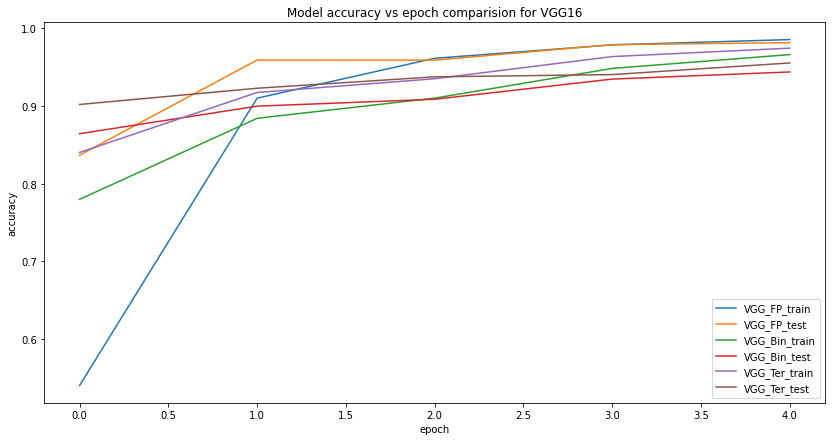

In [101]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(VGG16FPhistory.history['accuracy'])
plt.plot(VGG16FPhistory.history['val_accuracy'])
plt.plot(VGG16Binaryhistory.history['accuracy'])
plt.plot(VGG16Binaryhistory.history['val_accuracy'])
plt.plot(VGG16Ternaryhistory.history['accuracy'])
plt.plot(VGG16Ternaryhistory.history['val_accuracy'])
plt.title('Model accuracy vs epoch comparision for VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['VGG_FP_train', 'VGG_FP_test','VGG_Bin_train', 'VGG_Bin_test','VGG_Ter_train', 'VGG_Ter_test'], loc='lower right')
plt.show()


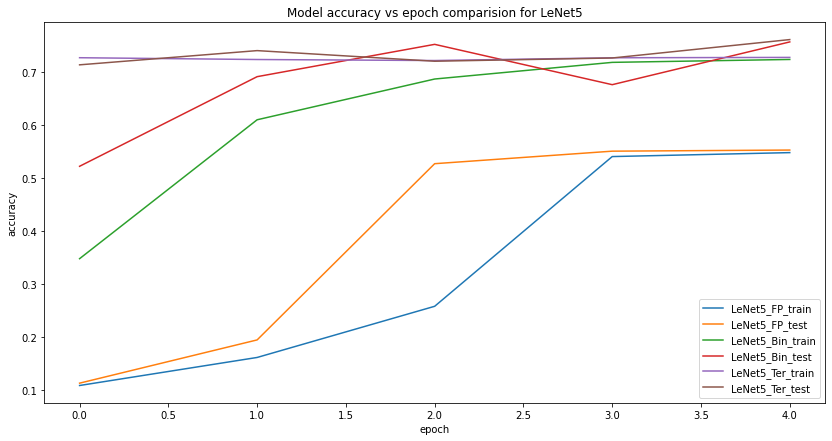

In [102]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(LeNet5FPhistory.history['accuracy'])
plt.plot(LeNet5FPhistory.history['val_accuracy'])
plt.plot(LeNet5Binaryhistory.history['accuracy'])
plt.plot(LeNet5Binaryhistory.history['val_accuracy'])
plt.plot(LeNet5Ternaryhistory.history['accuracy'])
plt.plot(LeNet5Ternaryhistory.history['val_accuracy'])
plt.title('Model accuracy vs epoch comparision for LeNet5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LeNet5_FP_train', 'LeNet5_FP_test','LeNet5_Bin_train', 
            'LeNet5_Bin_test','LeNet5_Ter_train', 'LeNet5_Ter_test'], loc='lower right')
plt.show()

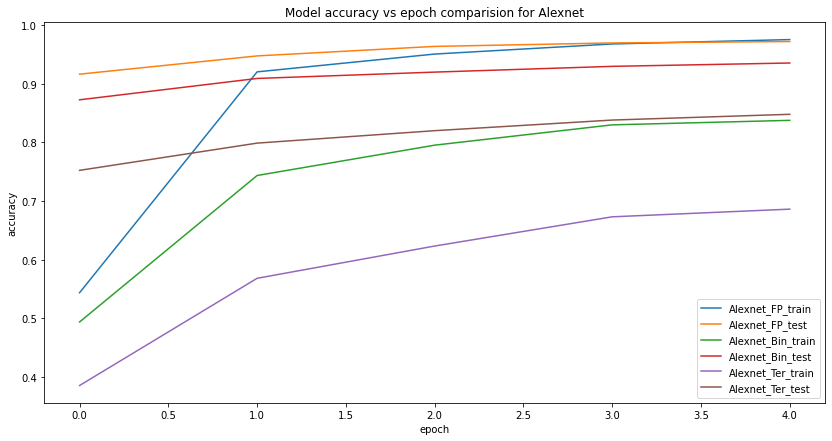

In [103]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(AlexnetFPhistory.history['accuracy'])
plt.plot(AlexnetFPhistory.history['val_accuracy'])
plt.plot(AlexnetBinaryHistory.history['accuracy'])
plt.plot(AlexnetBinaryHistory.history['val_accuracy'])
plt.plot(AlexnetTernaryHistory.history['accuracy'])
plt.plot(AlexnetTernaryHistory.history['val_accuracy'])
plt.title('Model accuracy vs epoch comparision for Alexnet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Alexnet_FP_train', 'Alexnet_FP_test','Alexnet_Bin_train', 
            'Alexnet_Bin_test','Alexnet_Ter_train', 'Alexnet_Ter_test'], loc='lower right')
plt.show()

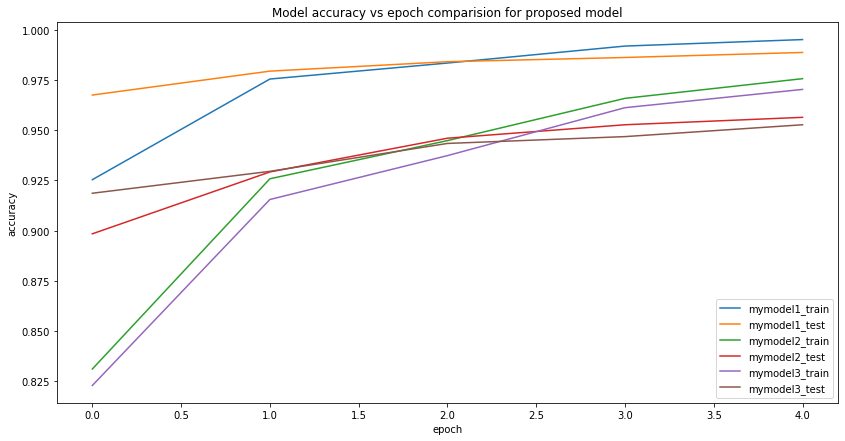

In [104]:
plt.rcParams["figure.figsize"] = (14,7)
plt.plot(mymodel1history.history['accuracy'])
plt.plot(mymodel1history.history['val_accuracy'])
plt.plot(mymodel2history.history['accuracy'])
plt.plot(mymodel2history.history['val_accuracy'])
plt.plot(mymodel3history.history['accuracy'])
plt.plot(mymodel3history.history['val_accuracy'])
plt.title('Model accuracy vs epoch comparision for proposed model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['mymodel1_train', 'mymodel1_test','mymodel2_train', 
            'mymodel2_test','mymodel3_train', 'mymodel3_test'], loc='lower right')
plt.show()

## Saving models

In [106]:
mymodel1.save(filepath = "./model/mymodel1")
mymodel2.save(filepath = "./model/mymodel2")
mymodel3.save(filepath = "./model/mymodel3")

INFO:tensorflow:Assets written to: ./model/mymodel1/assets
INFO:tensorflow:Assets written to: ./model/mymodel2/assets
INFO:tensorflow:Assets written to: ./model/mymodel3/assets


In [112]:
AlexnetBinary.save(filepath = "./model/AlexnetBinary")
AlexnetTernary.save(filepath = "./model/AlexnetTernary")
AlexnetFP.save(filepath = "./model/AlexnetFP")

INFO:tensorflow:Assets written to: ./model/AlexnetBinary/assets
INFO:tensorflow:Assets written to: ./model/AlexnetTernary/assets
INFO:tensorflow:Assets written to: ./model/AlexnetFP/assets


In [114]:
LeNet5Binary.save(filepath = "./model/Lenet5Binary")
LeNet5Ternary.save(filepath = "./model/Lenet5Ternary")
LeNet5FP.save(filepath = "./model/Lenet5FP")

INFO:tensorflow:Assets written to: ./model/Lenet5Binary/assets
INFO:tensorflow:Assets written to: ./model/Lenet5Ternary/assets
INFO:tensorflow:Assets written to: ./model/Lenet5FP/assets


In [1]:
!sudo apt-get install tree
!tree ./ >> README.md

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following packages were automatically installed and are no longer required:
  libnuma1 linux-gcp-5.4-headers-5.4.0-1052 linux-gcp-5.4-headers-5.4.0-1053
  linux-gcp-5.4-headers-5.4.0-1055 linux-gcp-5.4-headers-5.4.0-1056
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
